In [1]:
%%time

import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def scaling(x, min, max):
    return np.where(x < min, 0.0, np.where(x > max, 1.0, (x - min) / (max - min)))

early_stopping = EarlyStopping(
    monitor='val_loss',  # 
    patience=500,        # 
    verbose=1,          # 
    mode='min',         # 
    restore_best_weights=True  # 
)

2023-12-03 18:31:53.277390: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 18:31:53.357385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 18:31:53.357436: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 18:31:53.357487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 18:31:53.374161: I tensorflow/core/platform/cpu_feature_g

2.14.0
CPU times: user 4.61 s, sys: 2.86 s, total: 7.47 s
Wall time: 4.7 s


In [2]:
SAVE_DIR = "../data"
file_criteo = SAVE_DIR + "/criteo-uplift-v2.1.csv"
df_criteo_ori = pd.read_csv(file_criteo, sep=',')

In [ ]:
df_criteo_ori.describe()

In [4]:
%%time

sample = 0.15
random_state=20220720
df_criteo=df_criteo_ori.sample(frac=sample, random_state=random_state).reset_index(drop=True)
X = df_criteo[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values

X[:, 0] = scaling(X[:, 0], min=np.min(X[:, 0]), max=np.max(X[:, 0]))
X[:, 1] = scaling(X[:, 1], min=np.min(X[:, 1]), max=np.max(X[:, 1]))
X[:, 2] = scaling(X[:, 2], min=np.min(X[:, 2]), max=np.max(X[:, 2]))
X[:, 3] = scaling(X[:, 3], min=np.min(X[:, 3]), max=np.max(X[:, 3]))
X[:, 4] = scaling(X[:, 4], min=np.min(X[:, 4]), max=np.max(X[:, 4]))
X[:, 5] = scaling(X[:, 5], min=np.min(X[:, 5]), max=np.max(X[:, 5]))
X[:, 6] = scaling(X[:, 6], min=np.min(X[:, 6]), max=np.max(X[:, 6]))
X[:, 7] = scaling(X[:, 7], min=np.min(X[:, 7]), max=np.max(X[:, 7]))
X[:, 8] = scaling(X[:, 8], min=np.min(X[:, 8]), max=np.max(X[:, 8]))
X[:, 9] = scaling(X[:, 9], min=np.min(X[:, 9]), max=np.max(X[:, 9]))
X[:, 10] = scaling(X[:, 10], min=np.min(X[:, 10]), max=np.max(X[:, 10]))
X[:, 11] = scaling(X[:, 11], min=np.min(X[:, 11]), max=np.max(X[:, 11]))

T = df_criteo['treatment'].values.reshape(-1, 1)
Y_visit = df_criteo['visit'].values.reshape(-1, 1)
Y_conv = df_criteo['conversion'].values.reshape(-1, 1)

T.shape, Y_visit.shape, Y_conv.shape


# calculate len
train_len = int(len(X) * 0.70)
cali_len = int(len(X) * 0.05)
test_len = len(X) - train_len - cali_len

# obtain train set
X_train = X[:train_len, :]
T_train = T[:train_len, :]
Y_visit_train = Y_visit[:train_len, :]
Y_conv_train = Y_conv[:train_len, :]

# obtain calibration set
X_cali = X[train_len:train_len+cali_len, :]
T_cali = T[train_len:train_len+cali_len, :]
Y_visit_cali = Y_visit[train_len:train_len+cali_len, :]
Y_conv_cali = Y_conv[train_len:train_len+cali_len, :]

# obtain test set
X_test = X[train_len+cali_len:, :]
T_test = T[train_len+cali_len:, :]
Y_visit_test = Y_visit[train_len+cali_len:, :]
Y_conv_test = Y_conv[train_len+cali_len:, :]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

# make covariate shift
condition_cali = (X_cali[:, 0] > 0.3) & (X_cali[:, 1] < 0.7)
X_cali = X_cali[condition_cali]
T_cali = T_cali[condition_cali]
Y_visit_cali = Y_visit_cali[condition_cali]
Y_conv_cali = Y_conv_cali[condition_cali]

condition_test = (X_test[:, 0] > 0.3) & (X_test[:, 1] < 0.7)
X_test = X_test[condition_test]
T_test = T_test[condition_test]
Y_visit_test = Y_visit_test[condition_test]
Y_conv_test = Y_conv_test[condition_test]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

1467857 (1467857, 12) (524236, 12) 2096939 (104846, 12)
1467857 (1467857, 12) (327160, 12) 2096939 (65226, 12)
CPU times: user 822 ms, sys: 176 ms, total: 998 ms
Wall time: 995 ms


# TPM-SL method:

### Train model

In [ ]:
count = 1

In [ ]:
# S LEARNER MODEL
# Y_conv
# 1e-5
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *

# final_model = get_slearner_criteo_model()
# final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
# #lambda y_true,y_pred: y_pred
# print('trainable_weights')
# for x in final_model.trainable_weights:
#     print(x.name)
# print('non_trainable_weights')
# for x in final_model.non_trainable_weights:
#     print(x.name)
# final_model.summary()


for i in range(count):

    print("iteration = ", i + 1)
    
    final_model = get_slearner_criteo_model()
    final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
    
    mcp_save = ModelCheckpoint('../model_file/roi/criteo/final_model/direct_ratio_SL/c_slearner_criteo_conv_model_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit([X_train, T_train], Y_conv_train, validation_split=0.2, epochs=200, batch_size=5000, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    final_model = get_slearner_criteo_model()
    final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
    
    mcp_save = ModelCheckpoint('../model_file/uplift/criteo/final_model/slearner/c_slearner_criteo_model_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit([X_train, T_train], Y_visit_train, validation_split=0.2, epochs=200, batch_size=5000, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    

### predict

iteration =  1
10224/10224 [==============================] - 19s 2ms/step
auc0.9446582854539324
mse0.0011576675238080892
10224/10224 [==============================] - 19s 2ms/step


/root/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


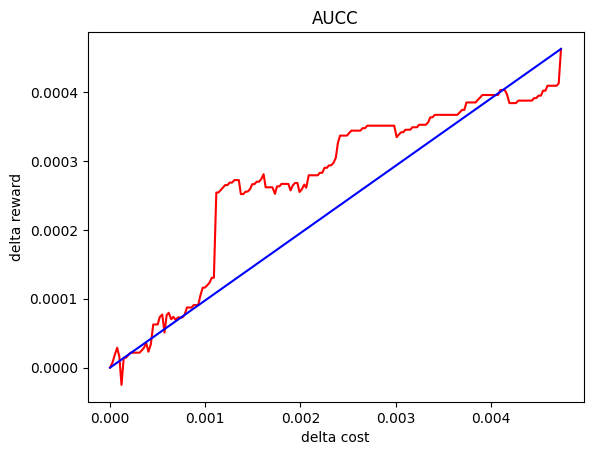

,delta_cost,delta_reward,n_treatment,n_control,roi_pred_treatment,roi_pred_control
0,0.000000,0.000000,0,0,0.000000,0.000000
1,0.000025,0.000007,8,0,3289.690186,NaN
2,0.000048,0.000018,28,3,945.465027,9.037660
3,0.000075,0.000029,50,6,531.378418,6.831866
4,0.000098,0.000016,72,8,370.086487,5.996416
...,...,...,...,...,...,...
196,0.004644,0.000409,148497,26336,0.255187,0.078140
197,0.004667,0.000409,148857,26399,0.254582,0.077965
198,0.004692,0.000409,148906,26410,0.254500,0.077935
199,0.004714,0.000413,149062,26450,0.254238,0.077824


AUCC =  0.5851408647567825




In [11]:
import sklearn 
import sklearn.metrics
from metric.Metric import *
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *

direct_ratio_SL_aucc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_slearner_criteo_model()
    final_model.load_weights('../model_file/roi/criteo/final_model/direct_ratio_SL/c_slearner_criteo_conv_model_{}.h5'.format(i+1))
    Y_pre = final_model.predict([X_test, T_test])
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y_conv_test, Y_pre)
    print("auc"+str(sklearn.metrics.auc(fpr, tpr)))
    print("mse"+str(sklearn.metrics.mean_squared_error(Y_conv_test, Y_pre)))
    
    
    T0 = np.zeros(shape=T_test.shape)
    T1 = np.ones(shape=T_test.shape)

    p0 = final_model.predict([X_test,  T0])
    p1 = final_model.predict([X_test,  T1])

    slearner_conv_pre = p1 - p0
    
    final_model = get_slearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/slearner/c_slearner_criteo_model_{}.h5'.format(i+1))
    
    p0 = final_model.predict([X_test,  T0])
    p1 = final_model.predict([X_test,  T1])

    slearner_visit_pre = p1 - p0
    
    
    roi_slearner_pre = slearner_conv_pre / np.where(abs(slearner_visit_pre) < 1e-6, 1e-6, slearner_visit_pre)


    direct_ratio_SL_aucc = get_uplift_model_aucc(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_slearner_pre.flatten(), quantile=200)
    
    direct_ratio_SL_aucc_list.append(direct_ratio_SL_aucc)
    
    print("\n")


In [12]:
# store test aucc for pic 
import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve

A_direct_ratio_SL_aucc_list = get_aucc_cost_curve(direct_ratio_SL_aucc_list)
print("aucc = ", np.sum(A_direct_ratio_SL_aucc_list['delta_reward'].values) / (A_direct_ratio_SL_aucc_list['delta_reward'].values[-1] * 201))
A_direct_ratio_SL_aucc_list.to_csv("../figure/D_direct_ratio_SL_aucc_list.csv")

aucc =  0.5851408647567825


# TPM-XL method:

### Train model

iteration =  1
305804/305804 [==============================] - 227s 743us/step


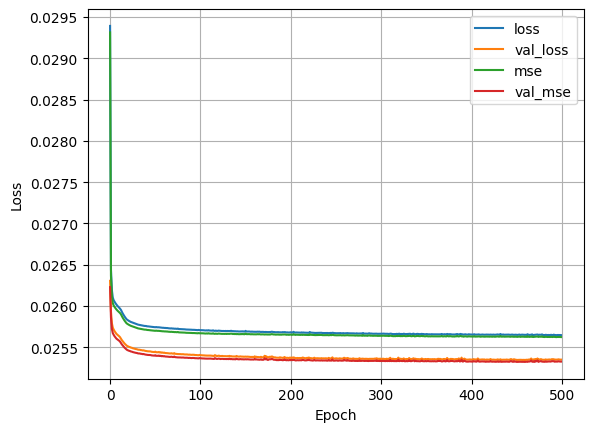

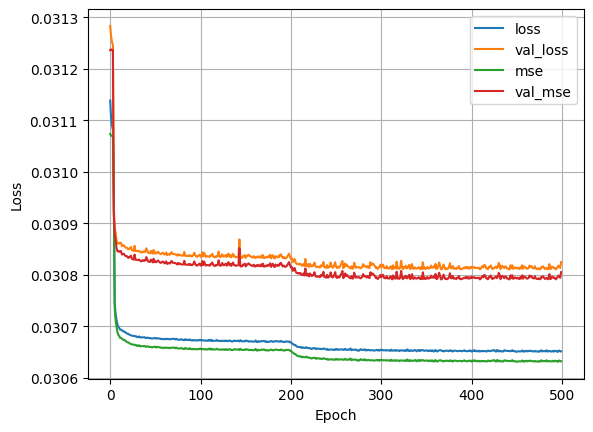

305804/305804 [==============================] - 226s 738us/step


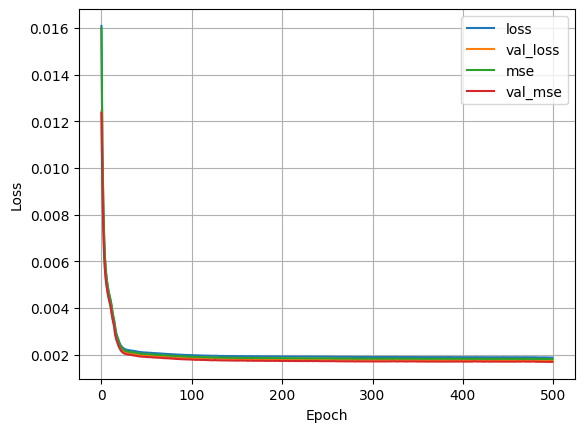

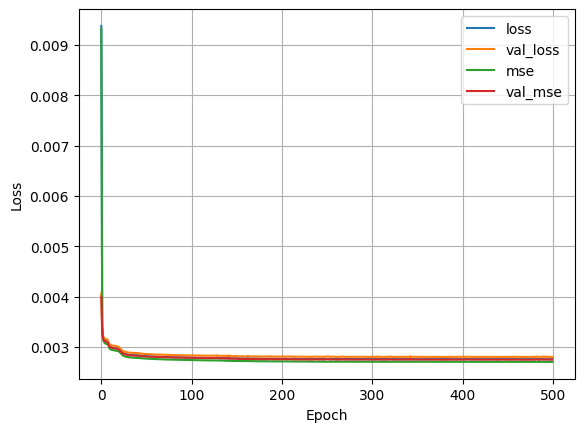

In [ ]:
# X LEARNER MODEL
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *

# final_model = get_xlearner_criteo_model()
# final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
# #lambda y_true,y_pred: y_pred
# print('trainable_weights')
# for x in final_model.trainable_weights:
#     print(x.name)
# print('non_trainable_weights')
# for x in final_model.non_trainable_weights:
#     print(x.name)
# final_model.summary()


for i in range(count):
    
    print("iteration = ", i + 1)
    
    # visit
    final_model = get_slearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/slearner/c_slearner_criteo_model_{}.h5'.format(i+1))
    T0 = np.zeros(shape=T_train.shape)
    T1 = np.ones(shape=T_train.shape)
    p0 = final_model.predict([X_train,  T0])
    p1 = final_model.predict([X_train,  T1])
    
    X_train_0 = X_train[(T_train.flatten() < 0.5), :]
    X_train_1 = X_train[(T_train.flatten() >= 0.5), :]

    X_train_0_p1_pre = p1[(T_train < 0.5)]
    X_train_1_p0_pre = p0[(T_train >= 0.5)]

    Y_visit_train_0 = Y_visit_train[(T_train < 0.5)]
    Y_visit_train_1 = Y_visit_train[(T_train >= 0.5)]

    tau_0_label = X_train_0_p1_pre - Y_visit_train_0
    tau_1_label = Y_visit_train_1 - X_train_1_p0_pre
    
    
    final_model = get_xlearner_criteo_model()
    final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    mcp_save = ModelCheckpoint('../model_file/uplift/criteo/final_model/xlearner/c_visit_xlearner_criteo_model_tau_0_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit(X_train_0, tau_0_label, validation_split=0.2, epochs=500, batch_size=32688, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    
    final_model = get_xlearner_criteo_model()
    final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    mcp_save = ModelCheckpoint('../model_file/uplift/criteo/final_model/xlearner/c_visit_xlearner_criteo_model_tau_1_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit(X_train_1, tau_1_label, validation_split=0.2, epochs=500, batch_size=32688, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    # conv
    
    final_model = get_slearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/slearner/c_slearner_criteo_model_{}.h5'.format(i+1))
    T0 = np.zeros(shape=T_train.shape)
    T1 = np.ones(shape=T_train.shape)
    p0 = final_model.predict([X_train,  T0])
    p1 = final_model.predict([X_train,  T1])
    
    X_train_0 = X_train[(T_train.flatten() < 0.5), :]
    X_train_1 = X_train[(T_train.flatten() >= 0.5), :]

    X_train_0_p1_pre = p1[(T_train < 0.5)]
    X_train_1_p0_pre = p0[(T_train >= 0.5)]

    Y_conv_train_0 = Y_conv_train[(T_train < 0.5)]
    Y_conv_train_1 = Y_conv_train[(T_train >= 0.5)]

    tau_0_label = X_train_0_p1_pre - Y_conv_train_0
    tau_1_label = Y_conv_train_1 - X_train_1_p0_pre
    
    
    final_model = get_xlearner_criteo_model()
    final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    mcp_save = ModelCheckpoint('../model_file/uplift/criteo/final_model/xlearner/c_conv_xlearner_criteo_model_tau_0_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit(X_train_0, tau_0_label, validation_split=0.2, epochs=500, batch_size=32688, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    
    final_model = get_xlearner_criteo_model()
    final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    mcp_save = ModelCheckpoint('../model_file/uplift/criteo/final_model/xlearner/c_conv_xlearner_criteo_model_tau_1_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit(X_train_1, tau_1_label, validation_split=0.2, epochs=500, batch_size=32688, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    print("\n")
    


### Predict

iteration =  1
10224/10224 [==============================] - 7s 667us/step


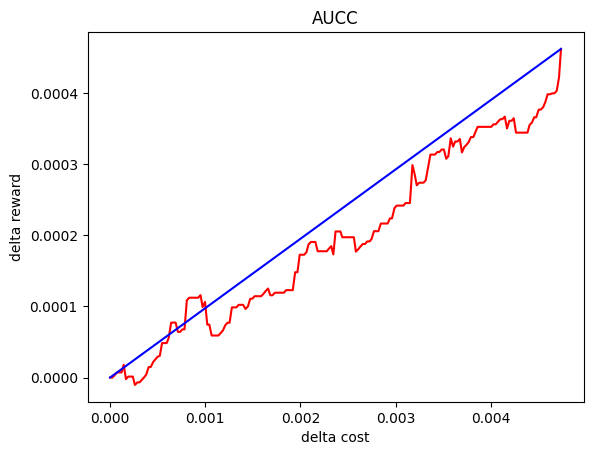

,delta_cost,delta_reward,n_treatment,n_control,roi_pred_treatment,roi_pred_control
0,0.000000,0.000000,0,0,0.000000,0.000000
1,0.000025,0.000000,750,130,1609.988892,1343.810547
2,0.000049,0.000004,2710,483,645.145874,568.437378
3,0.000073,0.000007,4283,773,450.095520,397.445740
4,0.000095,0.000007,4450,804,436.452087,385.455109
...,...,...,...,...,...,...
196,0.004646,0.000400,115731,20444,22.413254,20.658285
197,0.004667,0.000400,121868,21541,20.910795,19.228331
198,0.004693,0.000404,129847,22937,19.154249,17.590975
199,0.004717,0.000423,248489,43955,4.741095,3.905897


AUCC =  0.4214655174873747




In [10]:
import sklearn 
import sklearn.metrics

direct_ratio_XL_aucc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    # conv
    final_model = get_xlearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/xlearner/c_conv_xlearner_criteo_model_tau_0_{}.h5'.format(i+1))

    tau_0_pre = final_model.predict(X_test)

    final_model = get_xlearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/xlearner/c_conv_xlearner_criteo_model_tau_1_{}.h5'.format(i+1))

    tau_1_pre = final_model.predict(X_test)

    ex = 0.85
    
    xlearner_conv_pre = ex * tau_0_pre + (1 - ex) * tau_1_pre

#     xlearner_causalml_auuc = get_causalml_auuc(Y=Y_visit_test, T=T_test, ite_pred=xlearner_tau_pre)
    
#     xlearner_causalml_auuc_list.append(xlearner_causalml_auuc)
    # visit
    final_model = get_xlearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/xlearner/c_visit_xlearner_criteo_model_tau_0_{}.h5'.format(i+1))

    tau_0_pre = final_model.predict(X_test)

    final_model = get_xlearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/xlearner/c_visit_xlearner_criteo_model_tau_1_{}.h5'.format(i+1))

    tau_1_pre = final_model.predict(X_test)

    ex = 0.85
    
    xlearner_visit_pre = ex * tau_0_pre + (1 - ex) * tau_1_pre
    
    
    # roi
    
    roi_xlearner_pre = xlearner_conv_pre / np.where(abs(xlearner_visit_pre) < 1e-6, 1e-6, xlearner_visit_pre)


    direct_ratio_XL_aucc = get_uplift_model_aucc(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_xlearner_pre.flatten(), quantile=200)
    
    direct_ratio_XL_aucc_list.append(direct_ratio_XL_aucc)
    
    print("\n")

In [11]:
A_direct_ratio_XL_aucc_list = get_aucc_cost_curve(direct_ratio_XL_aucc_list)
print("aucc = ", np.sum(A_direct_ratio_XL_aucc_list['delta_reward'].values) / (A_direct_ratio_XL_aucc_list['delta_reward'].values[-1] * 201))
A_direct_ratio_XL_aucc_list.to_csv("../figure/D_direct_ratio_XL_aucc_list.csv")

aucc =  0.4214655174873747
